In [1]:
import os
import pandas as pd
import numpy as np
import minas as mg
import json
import joblib

# Caminho do arquivo de entrada
input_path = '../data/input_splusgL11.csv'
df_base = pd.read_csv(input_path)
df_base.set_index('TILE_ID', drop=True, inplace=True)

# Conjuntos de filtros
survey_filter = 'SPLUS'
filters = mg.FILTERS[survey_filter]

# Tipo de modelo: RF = random forest e XGB = xgboost
model_type = 'XGB'

In [2]:
# Ajuste automático do sufixo do survey_train conforme o nome do arquivo de entrada
if 'A' in os.path.basename(input_path):
    survey_train = f'{survey_filter}A'
elif 'L' in os.path.basename(input_path):
    survey_train = f'{survey_filter}L'
else:
    survey_train = survey_filter
datetime_str = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')

# Defina o config_id a ser usado (deve ser informado pelo usuário)
config_id = ''  # Exemplo, altere conforme necessário

# Parâmetros a serem usados
param_list = ['teff', 'logg', 'feh']

In [3]:

param_configs = []
print(f"Configurações carregadas para config_id: {config_id}\n")
for param in param_list:
    param_config = {}
    if param == 'teff':
        param_config['param_aliases'] = ['teff', 'Teff', 'TEFF', 'TEFF_ADOP', 'TEFF_SPEC', 'T_EFF', 'teff_2']
        param_config['bins'] = [3000, 4000, 5000, 6000, 7000, 8300]
    elif param == 'logg':
        param_config['param_aliases'] = ['logg', 'Logg', 'LOGG', 'log g', 'logg_2']
        param_config['bins'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    elif param == 'feh':
        param_config['param_aliases'] = ['feh', 'Feh', 'FEH', '[Fe/H]', '[M/H]']
        param_config['bins'] = [-2.5, -1.5, -0.5, 0.5, 1.0]
    # Cria pipeline conforme model_type usando minas
    if model_type == 'RF':
        param_config['pipeline'] = mg.models.create_model('RF-REG', None)
    elif model_type == 'XGB':
        param_config['pipeline'] = mg.models.create_model('XGB-REG', None)
    else:
        raise ValueError(f"Tipo de modelo não suportado: {model_type}")
    param_configs.append(param_config)

Configurações carregadas para config_id: 



### Graphics

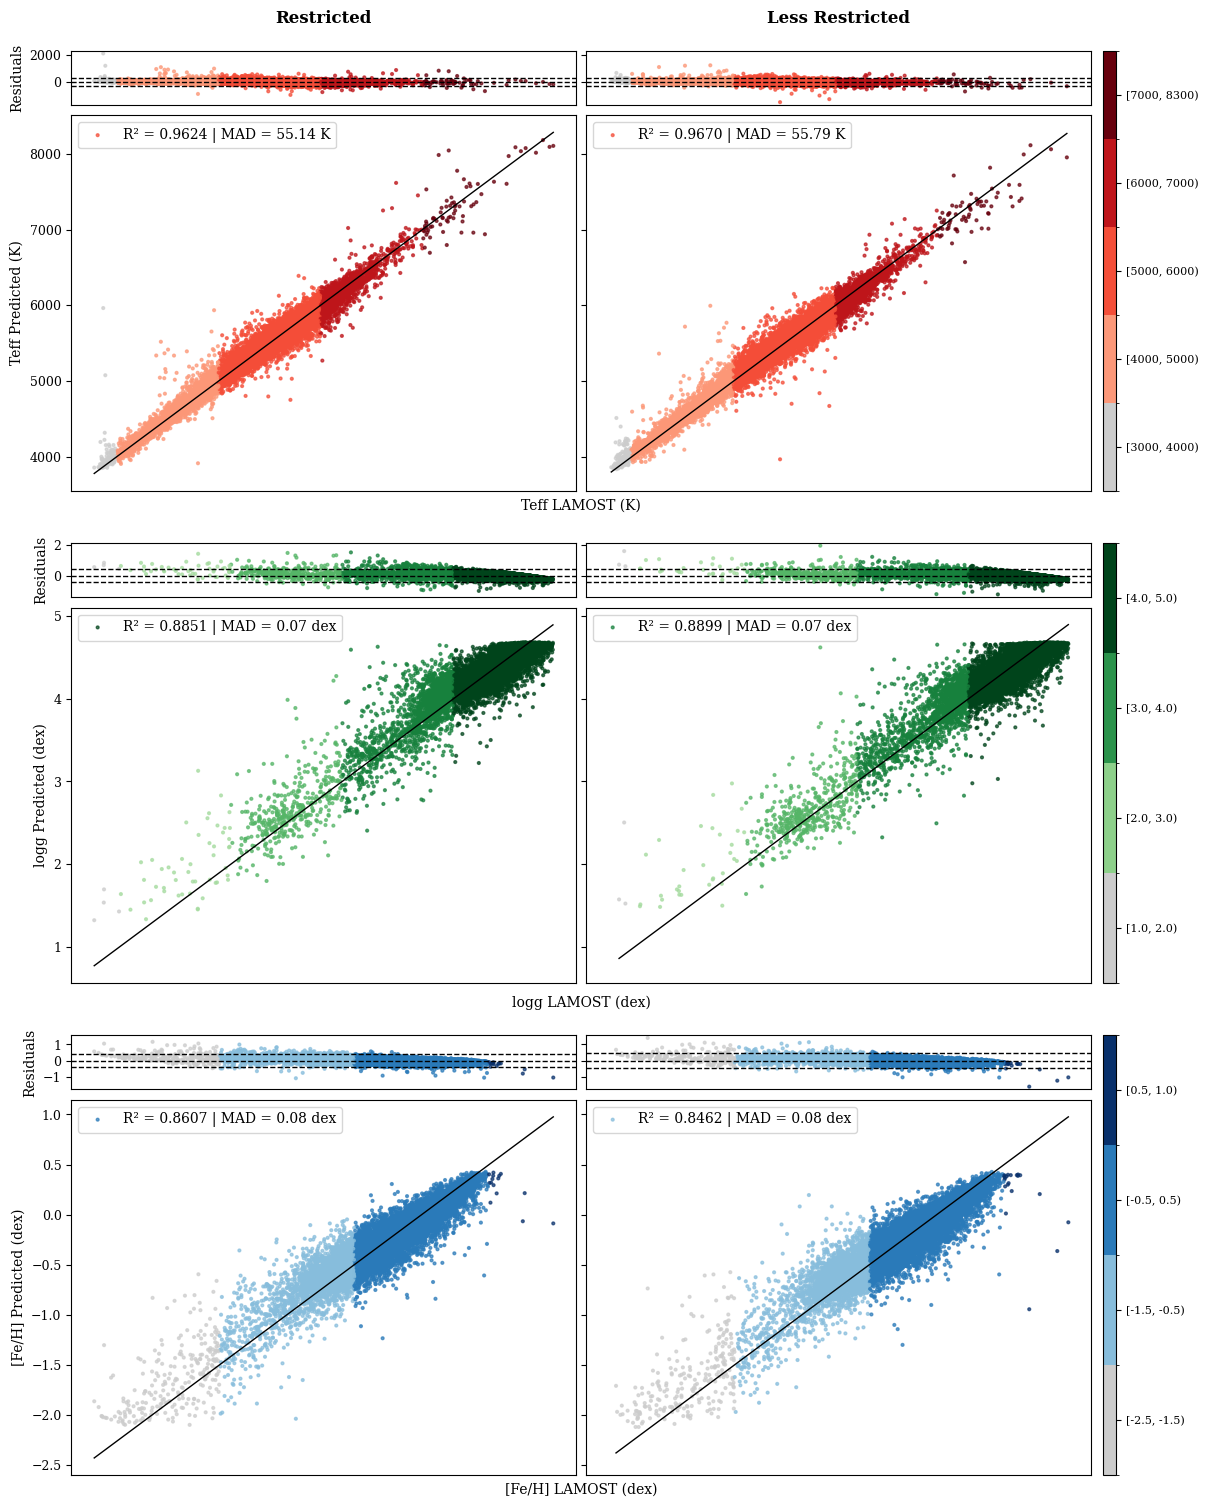


=== PLOTS COMPLETED ===


In [6]:
# --- Bloco para matriz de gráficos 3x2 (Restricted e Less Restricted) ---
import importlib
import minas.evaluation._graphics
importlib.reload(minas.evaluation._graphics)

training_ids = {
    'Restricted': 20251027174628,          # 01 ID para restrito
    'Less Restricted': 20251027175631      # 02 ID para menos restrito
}

results_dict = {}
bins_dict = {p: c['bins'] for p, c in zip(param_list, param_configs)}
metrics_json_paths = {}
survey_code = survey_train[-1] if len(survey_train) > len('SPLUS') else ''

for restr, tid in training_ids.items():
    sufixo = '_01' if restr == 'Restricted' else '_02'
    for param in param_list:
        results_path = f'predicts/{model_type}/{tid}_{survey_train}_{param}{sufixo}_{model_type}.csv'
        metrics_path = results_path.replace('.csv', '_metrics.json')
        key = f'{param}_{restr}'
        if not os.path.exists(results_path) or not os.path.exists(metrics_path):
            results_dict[key] = None
            metrics_json_paths[key] = None
            continue
        results_df = pd.read_csv(results_path, index_col=0)
        param_col = [col for col in results_df.columns if col not in ['Predicted', 'Residuos', 'RA', 'DEC']][0]
        results_dict[key] = (results_df[param_col], results_df['Predicted'])
        metrics_json_paths[key] = metrics_path

fig = mg.evaluation._graphics.plot_regression_matrix(
    results_dict=results_dict,
    bins_dict=bins_dict,
    param_order=param_list,
    titles=['Restricted', 'Less Restricted'],
    point_size=4,
    metrics_json_paths=metrics_json_paths,
    survey_name=survey_code
)
# Salvar figura usando padrão do mg
graphs_results = 'graphs_matrix'
os.makedirs(graphs_results, exist_ok=True)
fig.savefig(f"{graphs_results}/{datetime_str}_{survey_train}_{model_type}.png", bbox_inches='tight')
mg.evaluation._graphics.show(fig)

# --- End of matrix block ---

print("\n=== PLOTS COMPLETED ===")
